# get clean version of NPZD model together!

# todo:
- gather necessary processes, and put them into the package structure
- clean up components, and see how they can be simplified
- run model,check output
- create modification of light treatment
- create new plot to show comparison

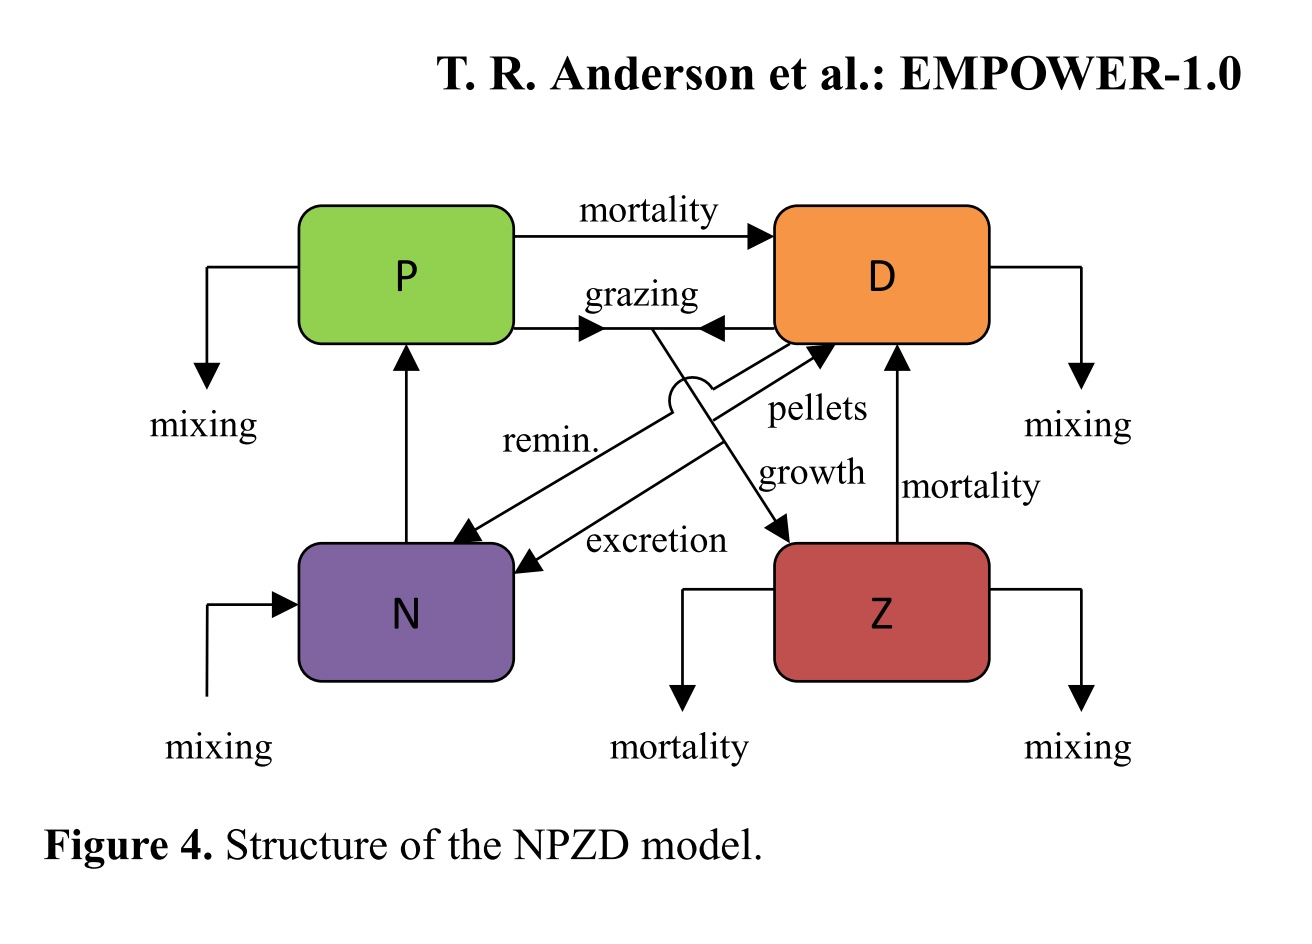

In [1]:
from IPython.display import Image
Image(filename=('empower_model_schematics.jpeg'), width=500)

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [4]:
from phydra.components.variables import SV

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.growth_multi_lim import Growth_ML, Eppley_ML, Monod_ML, Smith_ML
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import Mixing_K, SlabUpwelling_KfromGroup, SlabMixing_KfromGroup, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing, ConstantForcing

setting new attr method
read_intrp_forcing


In [5]:
from phydra.components.forcings import EMPOWER_IrradianceFromLat, EMPOWER_ForcingFromFile

from phydra.components.fluxes.EMPOWER_growth import (EMPOWER_Monod_ML, EMPOWER_Smith_ML, 
                                                     EMPOWER_Anderson_Light_ML,
                                                     EMPOWER_Eppley_ML,
                                                     EMPOWER_Growth_ML)

setting new attr method
FNLIcalcA93
setting new attr method
FNaphy
setting new attr method
SmithFunc


In [6]:
from phydra.components.forcings import NoonPARfromLat, IrradianceFromNoonPAR

In [7]:
NoonPARfromLat

phydra.backend.component.NoonPARfromLat

# CREATE MODEL

In [8]:
EMPOWER = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SV,
    'Zooplankton':SV,
    'Detritus':SV,
    
    # Mixing:
    'K':Mixing_K,
    'Upwelling':SlabUpwelling_KfromGroup,
    'Mixing':SlabMixing_KfromGroup,
    'Sinking':SlabSinking,

    # Growth
    'Growth':EMPOWER_Growth_ML,
    'Nut_lim':EMPOWER_Monod_ML,
    'Light_lim':EMPOWER_Anderson_Light_ML,
    'Temp_lim':EMPOWER_Eppley_ML,
    
    # Grazing
    'Grazing':HollingTypeIII_ResourcesListInput_Consumption2Group,
    'GGE':GrossGrowthEfficiency,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange,
    'PhytoQuadMortality':QuadraticExchange,
    'ZooLinMortality':LinearExchange,
    'HigherOrderPred':QuadraticDecay,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'NoonPAR':NoonPARfromLat,
    'Irradiance':EMPOWER_IrradianceFromLat,
    'Forcings':EMPOWER_ForcingFromFile,
                     })

In [9]:
#EMPOWER_smith = EMPOWER.update_processes({'Light_lim':EMPOWER_Smith_ML})

In [10]:
print(EMPOWER)

<xsimlab.Model (25 processes, 66 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Zooplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Detritus
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Irradiance
    I0_label                 [in] label / calculated irradiance for...
    station                  [in] name of station, options: 'india'...
NoonPAR
    NoonPAR_label            [in] label / calculated PAR from Irrad...
    station                  [i

# SETUP MODEL

In [11]:
num_years = 5

batch_setup = phydra.setup(solver='odeint', model=EMPOWER,
            time=np.arange(0,365*num_years),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':10.},
                    'Phytoplankton':{'var_label':'P','var_init':.1},
                    'Zooplankton':{'var_label':'Z','var_init':.1},
                    'Detritus':{'var_label':'D','var_init':.1},
                
                    # Mixing:
                    'K':{'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Upwelling':{'n':'N', 'n_0':'N0'},
                    'Mixing':{'vars_sink':['P','Z','D']},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Nut_lim':{'resource':'N', 'halfsat':.85},
                    'Light_lim':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'alpha':('batch', [0.15, 0.15, 0.075, 0.075]), 'CtoChl':75.},
                    'Temp_lim':{'temp':'SST', 'VpMax':('batch', [2.5, 2.5, 1.25, 1.25])},

                    # Grazing
                    'Grazing':{'resources':['P','D'], 'consumer':'Z',
                           'feed_prefs':[.67,.33],'Imax':('batch', [1., 1., 1.25, 2.]), 'kZ':.6},
                    'GGE':{'assimilated_consumer':'Z', 'egested_detritus':'D', 'excreted_nutrient':'N', 
                           'epsilon':0.75, 'beta':0.69},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.015},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.025},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':('batch', [0.02, 0., 0.02, 0.02])},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.06},

                    # Forcings
                    'Irradiance':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                  'I0_label':'I0'},
                    'NoonPAR':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                  'NoonPAR_label':'noonPAR'},
                    'Forcings':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                'MLD_label':'MLD', 'SST_label':'SST',
                                'MLDderiv_label':'MLDderiv', 'N0_label':'N0'},
            })

# RUN MODEL

In [12]:
with EMPOWER:
    batch_out = batch_setup.xsimlab.run(batch_dim='batch')
    #tropical_out = tropical_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Irradiance
Initializing component NoonPAR
Initializing component Forcings
Initializing component K
K_mixing
Initializing component PhytoLinMortality
Initializing component Sinking
Initializing component DetRemineralisation
Initializing component Nut_lim
Nut_lim_monod_lim
Initializing component PhytoQuadMortality
Initializing component Temp_lim
Temp_lim_temp_dependence
Initializing component HigherOrderPred
Initializing component ZooLinMortality
Initializing component Grazing
Grazing_grazing
Initializing component Upwelling
Initializing component Mixing
Initializing component GGE
Initializing component Light_lim
Light_lim_irradiance_out
Initializing component Growth
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x15cc0f9a0>
Model is assembled:
Model cont

In [13]:
batch_out

<xarray.Dataset>
Dimensions:                           (batch: 4, clock: 2, input_time: 1825, resources: 2, sinking_vars: 3, sinking_vars_full: 3, time: 1825)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: batch, input_time, resources, sinking_vars, sinking_vars_full, time
Data variables:
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (batch, time) float64 0.005788 ... 0.00...
    DetRemineralisation__rate         float64 0.06
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 0.1
    Detritus__var_label               <U1 'D'
    Detritus__var_value               (batch, time) float64 0.1 ... 0.1033
    Forcings__MLD_label               <U3 'MLD'
    Forcings__MLD_value               (batch, time) float64 193.4 ... 88.71
    Forcings__MLDderiv_label          <U8 'MLDderiv'
    Forcings__MLDderiv_value          (batch, time) float64 3.199 ... -0.8153
    Forcings__N0_label                <U2 'N0'
    Forcings__N0_value                (batch, time) float64 7.364 7.42 ... 26.1
    Forcings__SST_label               <U3 'SST'
    Forcings__SST_value               (batch, time) float64 12.65 ... 3.326
    Forcings__station                 (batch) <U8 'biotrans' ... 'kerfix'
    GGE__assimilated_consumer         <U1 'Z'
    GGE__assimilation_value           (batch, time) float64 0.001323 ... 0.01577
    GGE__beta                         float64 0.69
    GGE__egested_detritus             <U1 'D'
    GGE__egestion_value               (batch, time) float64 0.0007928 ... 0.0...
    GGE__epsilon                      float64 0.75
    GGE__excreted_nutrient            <U1 'N'
    GGE__excretion_value              (batch, time) float64 0.0004412 ... 0.0...
    Grazing__Imax                     (batch) float64 1.0 1.0 1.25 2.0
    Grazing__consumer                 <U1 'Z'
    Grazing__feed_prefs               (resources) float64 0.67 0.33
    Grazing__grazing_value            (batch, resources, time) float64 0.0017...
    Grazing__kZ                       float64 0.6
    Grazing__resources                (resources) <U1 'P' 'D'
    Growth__consumer                  <U1 'P'
    Growth__growth_value              (batch, time) float64 0.004493 ... 0.0321
    Growth__mu_max                    float64 1.0
    Growth__resource                  <U1 'N'
    HigherOrderPred__decay_value      (batch, time) float64 0.003214 ... 0.01035
    HigherOrderPred__rate             float64 0.34
    HigherOrderPred__var              <U1 'Z'
    Irradiance__I0_label              <U2 'I0'
    Irradiance__I0_value              (batch, time) float64 410.4 ... 2.549e+03
    Irradiance__station               (batch) <U8 'biotrans' ... 'kerfix'
    K__kappa                          float64 0.13
    K__mixing_value                   (batch, time) float64 0.01708 ... 0.001459
    K__mld                            <U3 'MLD'
    K__mld_deriv                      <U8 'MLDderiv'
    Light_lim__CtoChl                 float64 75.0
    Light_lim__alpha                  (batch) float64 0.15 0.15 0.075 0.075
    Light_lim__i_0                    <U2 'I0'
    Light_lim__irradiance_out_value   (batch, time) float64 0.04893 ... 0.1547
    Light_lim__kc                     float64 0.03
    Light_lim__kw                     float64 0.04
    Light_lim__mld                    <U3 'MLD'
    Light_lim__pigment_biomass        <U1 'P'
    Mixing__mixing_value              (batch, sinking_vars_full, time) float64 ...
    Mixing__vars_sink                 (sinking_vars) <U1 'P' 'Z' 'D'
    NoonPAR__NoonPAR_label            <U7 'noonPAR'
    NoonPAR__NoonPAR_value            (batch, time) float64 82.44 ... 264.8
    NoonPAR__station                  (batch) <U8 'biotrans' ... 'kerfix'
    Nut_lim__halfsat                  float64 0.85
    Nut_lim__monod_lim_value          (batch, time) float64 0.9215 ... 0.9656
   

In [14]:
stations = list(batch_out.Forcings__station.values)

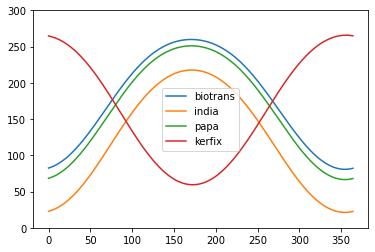

In [15]:
for i, label in zip(range(4), stations):
    plt.plot(batch_out.NoonPAR__NoonPAR_value.T[:365,i], label=label)
    plt.legend()
    plt.ylim(0,300)

In [18]:
plt.rcParams['figure.figsize'] = [12, 7]

last_year_slice = slice((num_years -1) * 365, num_years * 365)
last_year_slice

slice(1460, 1825, None)

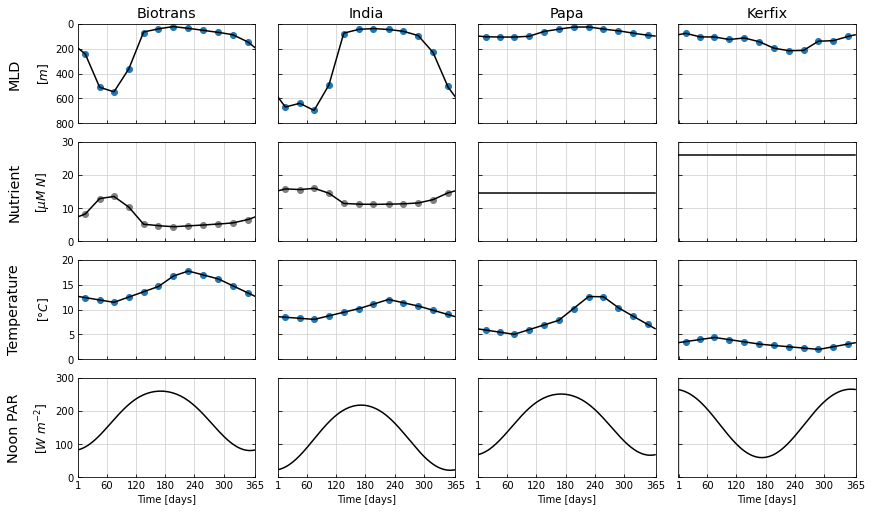

In [65]:
numcols = 4
f1, (ax1, ax2, ax3, ax4) = plt.subplots(4, numcols, sharex='col', constrained_layout=True)  #, sharey='row')

plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3, ax4):
    for i in range(numcols):
        axe[i].grid(True, color='lightgrey')
        #axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        
def modeloutputplot(i, dataset, verifdata, secondaryline=False):
    timedays_ly = dataset.Time__time[0:365]
    
    color = "black"
    
    N_Max = 800 #np.max(dataset.Nutrient__var_value[last_year_slice]) + np.max(dataset.Nutrient__var_value[last_year_slice]) * 0.1
    #Pall = outarray_ly[:,1]    
    P_Max = 30 #np.max(ms.physics.forcing.verif.chla) + 0.9 * np.max(Pall)
    #Zall = outarray_ly[:,2]
    Z_Max = 20 #np.max(Zall) + 0.1 * np.max(Zall)
    D_Max = 300 #np.max(outarray_ly[:, 3]) + 0.2 * np.max(outarray_ly[:, 3])

    #print(outarrayx)

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    #print(timedays_ly)

    # Figure 1
    # N
    #print(np.max(dataset.Nutrient__var_value))
    if i == 0:  
        ax1[i].annotate('MLD',xy=(0, 1),rotation=90,xytext=(-145,N_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[0])
        ax1[i].set_ylabel('[$m$]', multialignment='center', fontsize=12)

        ax2[i].annotate('Nutrient',xy=(0, 1),rotation=90,xytext=(-145,P_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[1])
        ax2[i].set_ylabel('[$µM$ $N$]', multialignment='center', fontsize=12)

        ax3[i].annotate('Temperature',xy=(0, 1),rotation=90,xytext=(-145,Z_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[2])
        ax3[i].set_ylabel('$[°C]$', multialignment='center', fontsize=12)

        ax4[i].annotate('Noon PAR',xy=(0, 1),rotation=90,xytext=(-145,D_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[3])
        ax4[i].set_ylabel('[$W$ $m^{-2}$]', multialignment='center', fontsize=12)

    ax1[i].set_ylim(0, N_Max)

    ax1[i].plot(timedays_ly, dataset.Forcings__MLD_value[last_year_slice], c=color, label='three layer')
    ax1[i].scatter(dpm_cumsum, dataset.Forcings__MLD_value[last_year_slice][dpm_cumsum.astype(int)])
    ax1[i].invert_yaxis()
    
    ax2[i].plot(timedays_ly, dataset.Forcings__N0_value[last_year_slice], c=color,  label='three layer')
    if i < 2:
        ax2[i].scatter(dpm_cumsum, dataset.Forcings__N0_value[last_year_slice][dpm_cumsum.astype(int)], c='grey')
    ax2[i].set_ylim(0, P_Max)

    # Z
    ax3[i].plot(timedays_ly, dataset.Forcings__SST_value[last_year_slice], c=color, label='three layer')
    ax3[i].scatter(dpm_cumsum, dataset.Forcings__SST_value[last_year_slice][dpm_cumsum.astype(int)])
    ax3[i].tick_params('y', labelsize=10)
    ax3[i].set_ylim(0, Z_Max)
    #ax4[i_plot].set_title('Zooplankton')

    # D
    ax4[i].plot(timedays_ly, dataset.NoonPAR__NoonPAR_value[last_year_slice], c=color, label='three layer')
    ax4[i].set_ylim(0,D_Max)
    ax4[i].set_xlabel('Time [days]')

    if False:
        ax1[i].legend(fontsize='small')
        ax2[i].legend(fontsize='small')
        ax3[i].legend(fontsize='small')
        ax4[i].legend(fontsize='small')

    if i >= 1:
        ax1[i].set_yticklabels([])
        ax2[i].set_yticklabels([])
        ax3[i].set_yticklabels([])
        ax4[i].set_yticklabels([])
        #ax4[i].set_xlabel('[days]')
            

    
    
modeloutputplot(0, batch_out.isel(batch=0), None)
#modeloutputplot(0, batch_out_2.isel(batch=0), biotrans_verif_data, secondaryline=True)

modeloutputplot(1, batch_out.isel(batch=1), None)
#modeloutputplot(1, batch_out_2.isel(batch=1), biotrans_verif_data, secondaryline=True)

modeloutputplot(2, batch_out.isel(batch=2), None)
#modeloutputplot(2, batch_out_2.isel(batch=2), biotrans_verif_data, secondaryline=True)

modeloutputplot(3, batch_out.isel(batch=3), None)
#modeloutputplot(3, batch_out_2.isel(batch=3), biotrans_verif_data, secondaryline=True)

# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

ax1[0].set_title('Biotrans', size='x-large')
ax1[1].set_title('India', size='x-large')
ax1[2].set_title('Papa', size='x-large')
ax1[3].set_title('Kerfix', size='x-large')

for axe in (ax1, ax2, ax3, ax4):
    for i in range(4):
        axe[i].set_axisbelow(True)


# Setting the values for all axes.
plt.setp((ax1, ax2, ax3), xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig('02_EMPOWER_NPZD_FORCING.pdf', bbox_inches='tight')
plt.show()

In [22]:
import pandas

In [37]:
station = 'india'
data = 'MLD'

def get_EMPOWER_data(station, data):
    stations_dict = {'india': {'MLD': 'MLD_India', 'SST': 'SST_India'},
                             'biotrans': {'MLD': 'MLD_Biotrans', 'SST': 'SST_Biotrans'},
                             'kerfix': {'MLD': 'MLD_Kerfix', 'SST': 'SST_Kerfix'},
                             'papa': {'MLD': 'MLD_Papa', 'SST': 'SST_Papa'}}

    all_forcings = pandas.read_csv("stations_forcing.txt", sep=r'\s*,\s*',
                                   header=0, encoding='ascii', engine='python')

    station_data = all_forcings[stations_dict[station][data]].values[:-1]

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm = dayspermonth
    dpm_cumsum = np.cumsum(dpm) - np.array(dpm) / 2

    boundary_int = [(station_data[0] + station_data[-1]) / 2]
    dat = np.concatenate([boundary_int, station_data, boundary_int], axis=None)

    time = np.concatenate([[0], dpm_cumsum, [365]], axis=None)
    
    data = {'time':time, 'data':dat}
    return pandas.DataFrame(data=data)

In [44]:
dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dpm = dayspermonth
dpm_cumsum = np.cumsum(dpm) - np.array(dpm) / 2

time = np.concatenate([[0], dpm_cumsum, [365]], axis=None)

In [46]:
dpm_cumsum

array([ 15.5,  45. ,  74.5, 105. , 135.5, 166. , 196.5, 227.5, 258. ,
       288.5, 319. , 349.5])

In [50]:
MLD = batch_out.isel(batch=0).Forcings__MLD_value[last_year_slice]

In [52]:
MLD

<xarray.DataArray 'Forcings__MLD_value' (time: 365)>
array([193.35473672, 196.55385197, 199.75296722, 202.95208246,
       206.15119771, 209.35031296, 212.5494282 , 215.74854345,
       218.9476587 , 222.14677394, 225.34588919, 228.54500444,
       231.74411968, 234.94323493, 238.14235017, 241.34146542,
       247.47069059, 256.53002568, 265.58936078, 274.64869587,
       283.70803096, 292.76736606, 301.82670115, 310.88603625,
       319.94537134, 329.00470643, 338.06404153, 347.12337662,
       356.18271171, 365.24204681, 374.3013819 , 383.36071699,
       392.42005209, 401.47938718, 410.53872227, 419.59805737,
       428.65739246, 437.71672755, 446.77606265, 455.83539774,
       464.89473283, 473.95406793, 483.01340302, 492.07273811,
       501.13207321, 510.1914083 , 511.44709144, 512.70277458,
       513.95845772, 515.21414086, 516.46982401, 517.72550715,
       518.98119029, 520.23687343, 521.49255657, 522.74823971,
       524.00392285, 525.25960599, 526.51528914, 527.77097228,
       529.02665542, 530.28233856, 531.5380217 , 532.79370484,
       534.04938798, 535.30507112, 536.56075426, 537.81643741,
       539.07212055, 540.32780369, 541.58348683, 542.83916997,
       544.09485311, 545.35053625, 546.60621939, 544.20582431,
       538.149351  , 532.0928777 , 526.03640439, 519.97993108,
...
        67.92436406,  68.51020871,  69.16060442,  69.81100014,
        70.46139585,  71.11179157,  71.76218728,  72.412583  ,
        73.06297872,  73.71337443,  74.36377015,  75.01416586,
        75.66456158,  76.31495729,  76.96535301,  77.61574872,
        78.26614444,  78.91654015,  79.56693587,  80.21733158,
        80.8677273 ,  81.51812301,  82.16851873,  82.81891444,
        83.46931016,  84.11970587,  84.77010159,  85.4204973 ,
        86.07089302,  86.72128873,  87.37168445,  88.02208017,
        89.88866635,  91.75525254,  93.62183873,  95.48842491,
        97.3550111 ,  99.22159729, 101.08818348, 102.95476966,
       104.82135585, 106.68794204, 108.55452822, 110.42111441,
       112.2877006 , 114.15428679, 116.02087297, 117.88745916,
       119.75404535, 121.62063153, 123.48721772, 125.35380391,
       127.2203901 , 129.08697628, 130.95356247, 132.82014866,
       134.68673485, 136.55332103, 138.41990722, 140.28649341,
       142.15307959, 144.01966578, 146.51430655, 149.63700189,
       152.75969724, 155.88239258, 159.00508793, 162.12778327,
       165.25047862, 168.37317396, 171.49586931, 174.61856465,
       177.74126   , 180.86395534, 183.98665069, 187.10934603,
       190.23204138])
Dimensions without coordinates: time
Attributes:
    Phydra_store_out:  True
    description:       output of forcing value / Empower MLD Forcing

In [56]:
dpm_cumsum.astype(int)

array([ 15,  45,  74, 105, 135, 166, 196, 227, 258, 288, 319, 349])

In [57]:
MLD[dpm_cumsum.astype(int)]

<xarray.DataArray 'Forcings__MLD_value' (time: 12)>
array([241.34146542, 510.1914083 , 546.60621939, 362.51162511,
        70.51378116,  40.00121612,  22.4299245 ,  36.15627978,
        52.28555687,  67.92436406,  88.02208017, 144.01966578])
Dimensions without coordinates: time
Attributes:
    Phydra_store_out:  True
    description:       output of forcing value / Empower MLD Forcing